# Visualizing the embeddings in 2D

We will use t-SNE to reduce the dimensionality of the embeddings from 1536 to 2. Once the embeddings are reduced to two dimensions, we can plot them in a 2D scatter plot.

In [ ]:
! pip install -qU tiktoken
! pip install -qU openai

In [ ]:
import tiktoken

In [ ]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [ ]:
# load & inspect dataset
input_datapath = "/content/fine_food_reviews_1k.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
print(len(df))
df.head(2)

1000


,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [ ]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
print(len(df))
df.head(2)

1000


,ProductId,UserId,Score,Summary,Text,combined,n_tokens
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178


In [ ]:
from openai import OpenAI
import numpy as np
import pandas as pd
from typing import List, Optional

client = OpenAI(api_key="OPENAI_API_KEY", max_retries=5)

def get_embedding(text: str, model="text-embedding-3-small", **kwargs) -> List[float]:
    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = client.embeddings.create(input=[text], model=model, **kwargs)

    return response.data[0].embedding

# This may take a few minutes
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))
df.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.0359942801296711, -0.02117965929210186, -0...."
297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.07042013108730316, -0.03175969794392586, -..."


In [ ]:
df.to_csv("fine_food_reviews_with_embeddings_1k.csv", encoding='utf-8', index=False)

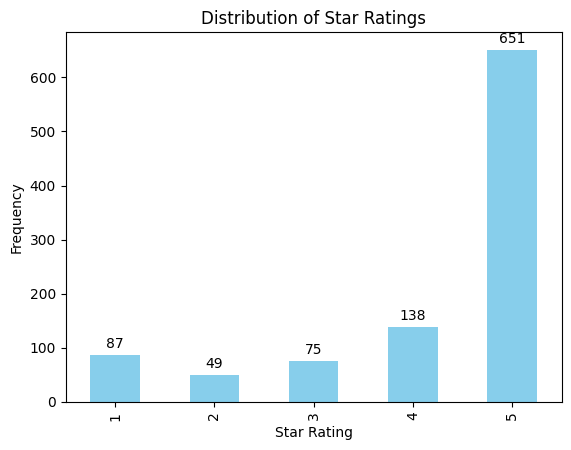

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram
bars = df['Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')

# Add labels to each bar
for bar in bars.patches:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords='offset points',
                 ha='center', va='bottom')

plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings')
plt.show()

## 1. Reduce dimensionality
We reduce the dimensionality to 2 dimensions using t-SNE decomposition.

t-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data.

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

# Convert to a list of floats
matrix = np.array(df.embedding.to_list())
print(type(matrix))
print(matrix.shape)

# Create a t-SNE model and transform the data
"""
Perplexity is a parameter that is related to the number of nearest neighbors that is used in other manifold learning algorithms.
It balances the focus between local and global aspects of the data.
A lower perplexity considers fewer neighbors, which can make the data more sensitive to local changes.
"""
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

<class 'numpy.ndarray'>
(1000, 1536)


(1000, 2)

## 2. Plotting the embeddings
We colour each review by its star rating, ranging from red to green.

We can observe a decent data separation even in the reduced 2 dimensions.

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

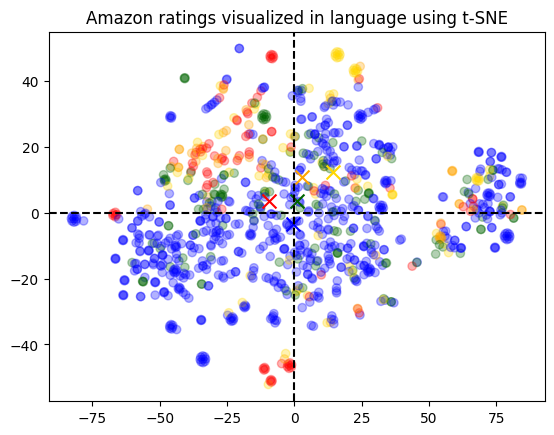

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "orange", "gold", "darkgreen", "blue"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.axhline(y=0, color='black', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')

plt.title("Amazon ratings visualized in language using t-SNE")

# Visualizing the embeddings in 3D

The example uses PCA to reduce the dimensionality fo the embeddings from 1536 to 3. Then we can visualize the data points in a 3D plot.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
vis_dims = pca.fit_transform(matrix)
print(vis_dims.shape)

df["embed_vis"] = vis_dims.tolist()

# Print the first two rows of the DataFrame showing only the specified column
print(df[["embed_vis"]].head(2))

(1000, 3)
                                             embed_vis
0    [0.1475079712076757, -0.0815082046606948, -0.0...
297  [-0.2737771088793203, 0.25465887679207727, 0.1...


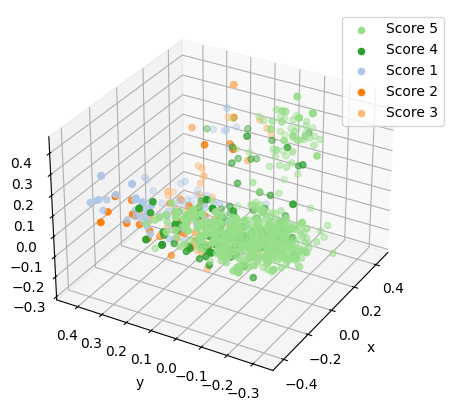

In [ ]:
# Use the inline magic command to ensure plots are displayed inline
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

# Plot each score with a different color
scores = df['Score'].unique()
cmap = plt.get_cmap("tab20")

for score, color in zip(scores, colors):
    subset = df[df['Score'] == score]
    pca_embeddings = np.array(subset['embed_vis'].tolist())
    ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], pca_embeddings[:, 2], color=cmap(score), label=f'Score {score}')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.1, 1))

# https://stackoverflow.com/questions/51940596/how-to-rotate-the-3d-scatter-plots-in-google-colaboratory
ax.view_init(elev=30, azim=-150)

plt.show()

In this 3D plot, it starts appearing to eyes that very few negative (1/2 starred) reviews are clearly separable from positive (4/5 starred) reviews but many others are embedded in tight neighbouring spaces. You wish we could do the visualization exercise in one more dimension and maybe the separation boxes/planes/lines would be even more clear.